# Intro

This notebook is to show how one can calculate a detector efficiency curve quickly.

We take the 'input_templateGX' Serpent2 input file template, create couple of similar files with different source energies, and run it. (the file itself has a simple HPGe detector model and a beam source shooting towards it.

Then we read the detector files, and fit a curve to the full peaks vs energy.

Note, in this example i have use a beam source, however for Part II of this study, one might want to include some surface source, and maybe even include the absorber sheets directly in the Serpent calculations.

## Create several input files

Run this cell only if you have Serpent2 installed and intend to redo the calculations. Otherwise the output files are already available in the subfolder 'simulations3/'.

In [ ]:
import numpy as np

energies=np.linspace(40,1927.86,25)

bashstr=''
refinp=open('input_templateGX').read()
for en in energies:
    newinp=refinp.replace('EnStr',str(en/1000))
    newfile=open('simulations3/input%d'%en,'w')
    newfile.write(newinp)
    newfile.close()
    bashstr=bashstr+'sss2 -omp 64 input%d\n'%en
    
bashfile=open('simulations3/run.sh','w')
bashfile.write(bashstr)
bashfile.close()
    

Now one should execute the run.sh bash file, and the detector outputs will be produced by Serpent2. Since the outputs are included with this notebook, one can start executing the cells from now on.

## Read detector outputs
We loop through the files, take the spectra, find the location of the maximum, and the sum it with the neigbouring bins.

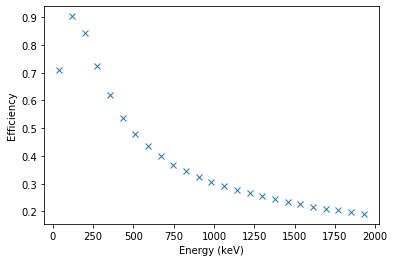

In [2]:
import matplotlib.pyplot as plt
import numpy as np

energies=np.linspace(40,1927.86,25)

peaks=[]
for en in energies:
    spectrumfile=open('simulations3/input%d_det0.m'%en).readlines()[2:4098]
    
    spectrum=[]
    for sp in spectrumfile:
        spectrum.append(float(sp.strip().split()[10]))
    
    ai=spectrum.index(max(spectrum))
    if en!=2000:
        peaks.append(spectrum[ai]+spectrum[ai-1]+spectrum[ai+1])
    else:
        peaks.append(spectrum[ai]+spectrum[ai-1])


plt.figure()
plt.plot(energies,peaks,'x')
plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.show()

## Curve fitting and defining a function

note that it seems illogical that i work with keV in the whole notebook, but then i define the function for MeV, the reason is because in an other notebook I work with MeV units

The function `detectorEff` is available in the `MVAfunctions` module.

In [3]:
peaks=np.array(peaks)
from scipy.optimize import curve_fit
p1,p2=curve_fit(lambda E,a,b,c,d,e,f: a+b*np.log(E/f)+c*(np.log(E/f))**2+d*(np.log(E/f))**3+e*(np.log(E/f))**4,  energies,  np.log(peaks))
print(p1)

[-8.02741343e-02 -1.49151904e-01 -2.84160334e-01  4.39778388e-02
  1.19674986e-03  1.26102944e+02]


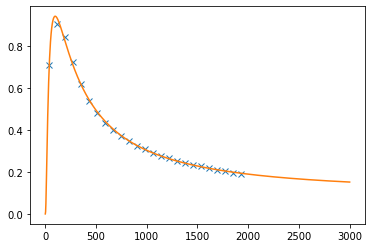

In [7]:
def detectorEff(E):
    E=E*1000 #change MeV to keV
    a=-8.02741343e-02
    b=-1.49151904e-01
    c=-2.84160334e-01
    d=4.39778388e-02
    e=1.19674986e-03
    f=1.26102944e+02
    
    lnEps=a+b*np.log(E/f)+c*(np.log(E/f))**2+d*(np.log(E/f))**3+e*(np.log(E/f))**4
    
    Eps=np.exp(lnEps)
    return Eps

plt.figure()
plt.plot(energies,peaks,'x')
plt.plot(1000*np.linspace(0.001,3,1000),detectorEff(np.linspace(0.001,3,1000)))
plt.show()